In [1]:
import numpy as np
import numpy.linalg as AL
import math
import scipy
from numpy import *
from scipy import *
from IPython.display import Latex
import skfuzzy as fuzz
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
%matplotlib inline 
from __future__ import division
import numpy as np
import math
import scipy
from numpy import *
from IPython.display import Latex
import skfuzzy as fuzz
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
%matplotlib inline 
from __future__ import division

Questao 1 (10.2)

In [2]:
dados = np.array([[0.6,0.2,0.0,0.8],[0.3,0.3,0.8,0.1],[0.1,0.5,0.2,0.1]])
dados

array([[ 0.6,  0.2,  0. ,  0.8],
       [ 0.3,  0.3,  0.8,  0.1],
       [ 0.1,  0.5,  0.2,  0.1]])

In [3]:
#Criando relacao de similaridade (Tolerância)
relacao_similaridade = fuzz.maxmin_composition(dados.transpose(),dados)
relacao_similaridade

array([[ 0.6,  0.3,  0.3,  0.6],
       [ 0.3,  0.5,  0.3,  0.2],
       [ 0.3,  0.3,  0.8,  0.1],
       [ 0.6,  0.2,  0.1,  0.8]])

In [4]:
#Criando relacao de similaridade (Equivalência) fazendo R composicao R n-1 vezes
for i in range(relacao_similaridade.shape[0]-1):
    relacao_similaridade = fuzz.maxmin_composition(relacao_similaridade,relacao_similaridade)
    print(relacao_similaridade)

[[ 0.6  0.3  0.3  0.6]
 [ 0.3  0.5  0.3  0.3]
 [ 0.3  0.3  0.8  0.3]
 [ 0.6  0.3  0.3  0.8]]
[[ 0.6  0.3  0.3  0.6]
 [ 0.3  0.5  0.3  0.3]
 [ 0.3  0.3  0.8  0.3]
 [ 0.6  0.3  0.3  0.8]]
[[ 0.6  0.3  0.3  0.6]
 [ 0.3  0.5  0.3  0.3]
 [ 0.3  0.3  0.8  0.3]
 [ 0.6  0.3  0.3  0.8]]


In [5]:
#Checando pra ver se realmente é de equivalência (Só a propriedade da transitividade fuzzy)
for i in range(4):
    for j in range(4):
        for k in range(4):
            if(relacao_similaridade[i][k]<min(relacao_similaridade[i][j],relacao_similaridade[j][k])):
                print('false %d %d %d' %(i,j,k))

In [6]:
def lambda_cut(matriz,level):
    for i in range(matriz.shape[0]):
        for j in range(matriz.shape[1]):
            if(matriz[i][j]>=level):
                matriz[i][j] = 1.0
            else:
                matriz[i][j] = 0.0
    return matriz

In [7]:
relacao_crisp = lambda_cut(relacao_similaridade,0.5)
relacao_crisp

array([[ 1.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  1.]])

Podemos ver que a divisão de grupos é {{x1,x4},{x2},{x3}}

##########################################################################

Questao 2 (10.5)

In [8]:
#irei logo criar as funções HCM e FCM que serão utilizadas nas próximas
#Funcoes uteis
def calcular_posicao_centroides(U,pontos):
    v = np.zeros((U.shape[0],pontos.shape[1]))
    dividendo,divisor = (0.0,0.0)
    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
            for k in range(U.shape[1]):
                dividendo = dividendo + (U[i][k] * pontos[k][j])
                divisor = divisor + U[i][k]
            v[i][j]=dividendo/divisor;
            dividendo,divisor = (0.0,0.0)
    return v
def calcular_posicao_centroides_fuzzy(U,pontos,m_linha):
    v = np.zeros((U.shape[0],pontos.shape[1]))
    dividendo,divisor = (0.0,0.0)
    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
            for k in range(U.shape[1]):
                dividendo = dividendo + ( (U[i][k])**m_linha * pontos[k][j])
                divisor = divisor + (U[i][k])**m_linha
            v[i][j]=dividendo/divisor;
            dividendo,divisor = (0.0,0.0)
    return v

def calcular_distancias(v,pontos):
    d = np.zeros((v.shape[0],pontos.shape[0]))
    for i in range(v.shape[0]):
        for j in range(pontos.shape[0]):
            for k in range(pontos.shape[1]):
                d[i][j] = d[i][j] + ( pontos[j][k] - v[i][k] )**2
            d[i][j] = np.sqrt(d[i][j])
    return d

def erro_total_particao(U,d):
    J_u_v = 0.0
    for i in range(d.shape[0]):
        for j in range(d.shape[1]):
            J_u_v = J_u_v + ( U[i][j] * (d[i][j])**2 )
    return J_u_v

def erro_total_particao_fuzzy(U,d,m_linha):
    J_u_v = 0.0
    for i in range(d.shape[0]):
        for j in range(d.shape[1]):
            J_u_v = J_u_v + ( (U[i][j])**m_linha * (d[i][j])**2 )
    return J_u_v

def realocar_pontos_HCM(U,d):
    U_new = np.zeros((U.shape[0],U.shape[1]))
    for j in range(U.shape[1]):
        pos = argmin(d[:,j])
        U_new[pos][j] = 1.0
    return U_new

def realocar_pontos_FCM(U,d,m_linha):
    U_new = np.zeros((U.shape[0],U.shape[1]))
    for i in range(U.shape[0]):    
        for j in range(U.shape[1]):
            for k in range(U.shape[0]):
                if(d[k][j]!=0): # para prevenir divisoes por 0
                    U_new[i][j] = U_new[i][j] + (d[i][j] / d[k][j])**(2.0/(m_linha-1.0))
            if(U_new[i][j]!=0):
                U_new[i][j] = U_new[i][j]**(-1)
    return U_new

def HCM(U,pontos,maxIteracoes):
    while(maxIteracoes > 0):
        v = calcular_posicao_centroides(U,pontos)
        #print(v)
        d = calcular_distancias(v,pontos)
        #print(d)
        U_new = realocar_pontos_HCM(U,d)
        print("Erro total: %f" %erro_total_particao(U,d))
        if(AL.norm(U_new - U )<0.01):
            break
        else:
            U = U_new
            maxIteracoes = maxIteracoes - 1;
    return U

def FCM(U,pontos,maxIteracoes,m_linha,epslon):
    while(maxIteracoes > 0):
        v = calcular_posicao_centroides_fuzzy(U,pontos,m_linha)
        #print(v)
        d = calcular_distancias(v,pontos)
        #print(d)
        U_new = realocar_pontos_FCM(U,d,m_linha)
        print("Erro total: %f" %erro_total_particao_fuzzy(U,d,m_linha))
        if(AL.norm(U_new - U )<epslon):
            break
        else:
            U = U_new
            maxIteracoes = maxIteracoes - 1;
    return U

def calcular_nivel_incerteza(U):
    n = U.shape[1]
    return np.trace(np.matmul(U , U.transpose()))/(n)

def calcular_relacao_similaridade(U):
    matriz_similaridade = np.zeros((U.shape[1],U.shape[1]))
    U_t = U.transpose()
    for i in range(matriz_similaridade.shape[0]):
        for j in range(matriz_similaridade.shape[1]):
            for k in range(U.shape[0]):
                matriz_similaridade[i][j] = matriz_similaridade[i][j] + min(U_t[i][k],U[k][j])
    return matriz_similaridade

In [9]:
X = np.array([[5,5],[6,8],[8,10],[9,12]])
U = np.array([[1,1,0,0],[0,0,1,1]])
U_new = FCM(U,X,200,2,0.01)
print("Resultado: U = \n",U_new)
print("\nO nível de inecerteza de U é: %f" %calcular_nivel_incerteza(U_new))
print("\nA relação de similaridade proveniente de U é: \n",calcular_relacao_similaridade(U_new))

Erro total: 7.500000
Erro total: 6.874403
Erro total: 6.854464
Erro total: 6.850617
Resultado: U = 
 [[ 0.96190154  0.82503041  0.05570918  0.02820576]
 [ 0.03809846  0.17496959  0.94429082  0.97179424]]

O nível de inecerteza de U é: 0.869491

A relação de similaridade proveniente de U é: 
 [[ 1.          0.86312888  0.09380764  0.06630422]
 [ 0.86312888  1.          0.23067877  0.20317534]
 [ 0.09380764  0.23067877  1.          0.97249657]
 [ 0.06630422  0.20317534  0.97249657  1.        ]]


#####################################################################

Questao 3 (10.8)

In [10]:
exemplos = np.array([[-3.,1.],[-2.,2],[-1.,-1.5],[1.,2.]])
U = np.array([[1,0,0,0],[0,1,1,1]])
U_new = FCM(U,exemplos,3,2,0.01)
print("Resultado: U = \n",U_new)
print("\nO nível de inecerteza de U é: %f" %calcular_nivel_incerteza(U_new))
print("\nA relação de similaridade proveniente de U é: \n",calcular_relacao_similaridade(U_new))

Erro total: 12.833333
Erro total: 11.330637
Erro total: 8.303686
Resultado: U = 
 [[ 0.64087995  0.76414446  0.36061453  0.47476499]
 [ 0.35912005  0.23585554  0.63938547  0.52523501]]

O nível de inecerteza de U é: 0.554842

A relação de similaridade proveniente de U é: 
 [[ 1.          0.87673548  0.71973458  0.83388505]
 [ 0.87673548  1.          0.59647007  0.71062053]
 [ 0.71973458  0.59647007  1.          0.88584953]
 [ 0.83388505  0.71062053  0.88584953  1.        ]]


######################################################################

Questao 4 (10.11)

In [11]:
tipos = np.array([[0.679,85.5,2.25],[0.7056,93.0,2.177],[0.701,91.0,2.253],[0.718,98.3,2.177]])
U = np.array([[0,1,1,0],[1,0,0,1]])
U_new = FCM(U,tipos,10,2,0.01)
print("Resultado: U = \n", U_new)
print("\nO nível de inecerteza de U é: %f" %calcular_nivel_incerteza(U_new))
print("\nA relação de similaridade proveniente de U é: \n",calcular_relacao_similaridade(U_new))

Erro total: 83.926324
Erro total: 41.908824
Erro total: 41.143728
Erro total: 37.243123
Erro total: 31.572574
Erro total: 26.429527
Erro total: 24.386861
Erro total: 24.094132
Erro total: 24.051846
Erro total: 24.024215
Resultado: U = 
 [[ 0.03620567  0.79499328  0.34808701  0.9490095 ]
 [ 0.96379433  0.20500672  0.65191299  0.0509905 ]]

O nível de inecerteza de U é: 0.763407

A relação de similaridade proveniente de U é: 
 [[ 1.          0.24121239  0.68811866  0.08719617]
 [ 0.24121239  1.          0.55309373  0.84598378]
 [ 0.68811866  0.55309373  1.          0.39907751]
 [ 0.08719617  0.84598378  0.39907751  1.        ]]


Tentei algumas métricas de normalizações mas os resultados foram piores.

In [12]:
tipos = np.array([[0.679,85.5,2.25],[0.7056,93.0,2.177],[0.701,91.0,2.253],[0.718,98.3,2.177]])
tipos[:,1] = tipos[:,1]/98.3
tipos[:,2] = tipos[:,2]/2.253
U = np.array([[0,1,1,0],[1,0,0,1]])
U_new = FCM(U,tipos,10,2,0.01)
print("Resultado: U = \n", U_new)
print("\nO nível de inecerteza de U é: %f" %calcular_nivel_incerteza(U_new))
print("\nA relação de similaridade proveniente de U é: \n",calcular_relacao_similaridade(U_new))

Erro total: 0.010550
Erro total: 0.005280
Erro total: 0.005196
Erro total: 0.004621
Erro total: 0.003636
Erro total: 0.003070
Erro total: 0.002901
Erro total: 0.002875
Erro total: 0.002871
Erro total: 0.002870
Resultado: U = 
 [[ 0.04037439  0.83793889  0.27787268  0.95158111]
 [ 0.95962561  0.16206111  0.72212732  0.04841889]]

O nível de inecerteza de U é: 0.789362

A relação de similaridade proveniente de U é: 
 [[ 1.          0.2024355   0.76250171  0.08879328]
 [ 0.2024355   1.          0.43993379  0.88635778]
 [ 0.76250171  0.43993379  1.          0.32629157]
 [ 0.08879328  0.88635778  0.32629157  1.        ]]


#################################################################################

Questao 5 (10.12)

In [13]:
condicoes = np.array([[1.,420.],[1.7,370.],[1.,260.],[9.,310.],[9.5,265]])
U = np.array([[1,0,1,0,1],[0,1,0,1,0]])
U_new = FCM(U,condicoes,10,2,0.01)

print("Resultado: U = \n", U_new)
print("\nO nível de inecerteza de U é: %f" %calcular_nivel_incerteza(U_new))
print("\nA relação de similaridade proveniente de U é: \n",calcular_relacao_similaridade(U_new))

Erro total: 18424.811667
Erro total: 6949.657435
Erro total: 3164.615433
Erro total: 2618.443263
Erro total: 2603.895207
Resultado: U = 
 [[ 0.03106503  0.06285678  0.98377436  0.86299843  0.99174471]
 [ 0.96893497  0.93714322  0.01622564  0.13700157  0.00825529]]

O nível de inecerteza de U é: 0.907445

A relação de similaridade proveniente de U é: 
 [[ 1.          0.96820825  0.04729067  0.1680666   0.03932032]
 [ 0.96820825  1.          0.07908243  0.19985836  0.07111207]
 [ 0.04729067  0.07908243  1.          0.87922407  0.99202965]
 [ 0.1680666   0.19985836  0.87922407  1.          0.87125371]
 [ 0.03932032  0.07111207  0.99202965  0.87125371  1.        ]]


Tentando normalizar :  (vou tentar deixar todos os valores com a mesma significancia, entre 0 e 1)

In [14]:
condicoes = np.array([[1.,420.],[1.7,370.],[1.,260.],[9.,310.],[9.5,265]])
condicoes[:,0] = condicoes[:,0]/9.5
condicoes[:,1] = condicoes[:,1]/420
print(condicoes)
U = np.array([[1,0,1,0,1],[0,1,0,1,0]])
U_new = FCM(U,condicoes,10,2,0.01)

print("Resultado: U = \n", U_new)
print("\nO nível de inecerteza de U é: %f" %calcular_nivel_incerteza(U_new))
print("\nA relação de similaridade proveniente de U é: \n",calcular_relacao_similaridade(U_new))

[[ 0.10526316  1.        ]
 [ 0.17894737  0.88095238]
 [ 0.10526316  0.61904762]
 [ 0.94736842  0.73809524]
 [ 1.          0.63095238]]
Erro total: 0.932963
Erro total: 0.382256
Erro total: 0.112099
Erro total: 0.082977
Resultado: U = 
 [[ 0.96601767  0.99442715  0.93843606  0.00365358  0.00699969]
 [ 0.03398233  0.00557285  0.06156394  0.99634642  0.99300031]]

O nível de inecerteza de U é: 0.957306

A relação de similaridade proveniente de U é: 
 [[ 1.          0.97159052  0.97241839  0.03763591  0.04098202]
 [ 0.97159052  1.          0.94400891  0.00922643  0.01257254]
 [ 0.97241839  0.94400891  1.          0.06521752  0.06856363]
 [ 0.03763591  0.00922643  0.06521752  1.          0.99665388]
 [ 0.04098202  0.01257254  0.06856363  0.99665388  1.        ]]


#########################################################################

Questao 5 (11.10)

In [39]:
velocidade = np.arange(5,20.1,0.1)
area = np.arange(50,170.1,0.1)

L_vel = fuzz.gaussmf(velocidade,5,3)
M_vel = fuzz.gaussmf(velocidade,10,5)
H_vel = fuzz.gaussmf(velocidade,15,3)

S_area = fuzz.gaussmf(area,50,26)
M_area = fuzz.gaussmf(area,100,18)
B_area = fuzz.gaussmf(area,150,4)

In [40]:
# velocidade = 8 e area = 120
x = np.array([8.,120.])
w = np.array([0.4,0.6])
print("x = ", x)
print("w = ", w)

x =  [   8.  120.]
w =  [ 0.4  0.6]


In [41]:
#note que 8 está em velocidade[30] e 120 está em area[700] , posicaoReal = (posicaoNumerica-baseNumerica)*10

low_rate = (w[0] * L_vel[30]) + (w[1] * S_area[700]) 
moderate_rate = (w[0] * M_vel[30]) + (w[1] * M_area[700])
high_rate = (w[0] * H_vel[30]) + (w[1] * B_area[700])

pertinencias = np.array([low_rate,moderate_rate,high_rate])
print("Pertinencias a low, moderate e high respectivamente:", pertinencias)

maior_pert = argmax(pertinencias) + 1
print("A amostra capturada pertence ao conjunto:",maior_pert)

Pertinencias a low, moderate e high respectivamente: [ 0.14757851  0.51543379  0.0017281 ]
A amostra capturada pertence ao conjunto: 2


2 = Moderate Flow

#################################################################

Questão 7 (11.11)

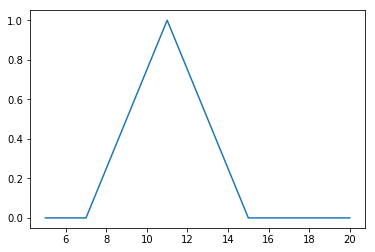

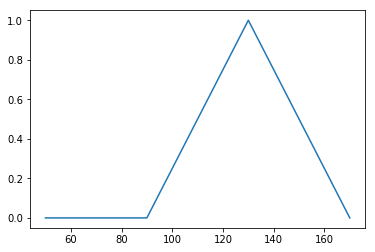

In [43]:
input_B_vel = fuzz.trimf(velocidade,[7,11,15])
input_B_area = fuzz.trimf(area,[90,130,170])

plt.figure()
plt.plot(velocidade,input_B_vel)
plt.figure()
plt.plot(area,input_B_area)

In [45]:
B_proximidade_1 = (w[0] * ((1./2.) * ( fuzz.inner_product(input_B_vel,L_vel) + (1. -  fuzz.outer_product(input_B_vel,L_vel))))) + (w[1] * ((1./2.) * ( fuzz.inner_product(input_B_area,S_area) + (1. -  fuzz.outer_product(input_B_area,S_area)))))
B_proximidade_1

0.58021869982287699

In [46]:
B_proximidade_2 = (w[0] * ((1./2.) * ( fuzz.inner_product(input_B_vel,M_vel) + (1. -  fuzz.outer_product(input_B_vel,M_vel))))) + (w[1] * ((1./2.) * ( fuzz.inner_product(input_B_area,M_area) + (1. -  fuzz.outer_product(input_B_area,M_area)))))
B_proximidade_2

0.86396064249314053

In [47]:
B_proximidade_3 = (w[0] * ((1./2.) * ( fuzz.inner_product(input_B_vel,H_vel) + (1. -  fuzz.outer_product(input_B_vel,H_vel))))) + (w[1] * ((1./2.) * ( fuzz.inner_product(input_B_area,B_area) + (1. -  fuzz.outer_product(input_B_area,B_area)))))
B_proximidade_3

0.78285910950604221

Logo, podemos ver que B está mais próximo do conjunto 2, Moderate Flow-Rate